In [1]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import pandas as pd
from pprint import pprint


In [2]:
def vel(m, h, P , P_electric = 250):
    ### aer. resistence
    Cd = 1.18
    A = 0.83 #m^2
    rho = 1.18 #kg/m^3

    c_Fd = rho*Cd*A*0.5

    ### rolling resistance
    Cr = 0.01
    g = 9.81 #m/s^2
    
    eta = 0.95
        
    c0 = P*eta
    c1 = (m*g* ( Cr*np.cos( np.arctan(h) ) + np.sin( np.arctan(h) ) ))
    c3 = c_Fd
    
    v_max = 30 #km/h
   ### closed form solution of 3-rd degree polynomial

    # p = c1/c3
    # q = -c0/c3
    # print(np.roots([1, 0, p, q]))
    
    ###
    coefs = [c3, 0, c1, -eta*P]
    coefs_electric = [c3, 0, c1, -eta*(P+P_electric)]        
    v = np.max(np.real(3.6*np.roots(coefs)))
    v_electric = np.max(np.real(3.6*np.roots(coefs_electric)))
    if v > 25:
        #print('up-cyclist only')
        return min(v, v_max)
    else:
        #print('up-electric')
        return min(v_electric, 25)


def time_matrix(data_matrix, load_levels,P):
    N = len(data_matrix.index)
    elevation = data_matrix.elevation.to_numpy()
    d_ij_mat = data_matrix.iloc[:, 8:].to_numpy()
    t_ij_mat = np.zeros((N, N, n_levels))
    for i in range(N):
        for j in range(N):
            if i!=j:
                d_ij = d_ij_mat[i, j]
                h = (elevation[j] - elevation[i])/d_ij
                for l in range(n_levels):
                    m = load_levels[l] + 140
                    #print(vel(m,h,P))
                    t_ij_mat[i, j, l] =60*d_ij/vel(m, h, P, P_electric=250)
    return np.round(t_ij_mat,4)

The forces acting on the bicyle are: the aerodynamic drag resistance $F_{D}$, the rolling resistance $F_{R}$ and the component of the gravity force along the direction of motion $F_{G}$:

* $ F_{D} = \frac{\rho C_{D}Av^{2}}{2}$
* $ F_{R} = C_{R}mg cos(arctan(h))$
* $ F_{G} = mg sin(arctan(h))$

We have to distinguish two cases: uphill and downhill.
In uphill, the component of the gravity force along the direction of motion is a resistance force, while in downhill it helps the motion of the bicyle.
so we have, at equilibrium:

* $\mathrm{ \eta P_{traction} = (F_{D} + (F_{R} + F_{G})v }$

where $\eta$ is the efficiency of the mechanic transmission, which is assumed to be 0.95.

If we use a negative h in the formuals above when traversing an edge with negative slope, since $cos(\alpha) = cos(-\alpha)$ and $sin(\alpha) = -sin(-\alpha)$, we have just one expression for the equation to solve.

Moreover, we assume that the bicyle speed is limited in downhill for safety reasons. Within cities, a typical speed limit for for motor vehicles is 50km/h. Considering also that the regulation for pedelec bicyle allows a maximum speed of 25km/h in electric assisted mode, we set a maximum speed in downhill of 30km/h.
The delta energy can be used for recharging the battery for example, similarly to other solutions in the automaotive industry.
The maximum speed limit is imposed on uphill as well.
The strategy for solving the equation is:
* solve the equation for the two cases: (1) $P=P_{cyclist}$, and (2) $P=P_{cyclist}+P_{electric}$ 
* If the cyclist can reach a speed that is higher than the speed allowed in electric mode, use that speed, subject to the limit of maximum speed allowed,
* otherwise use the minimum value among 25 km/h and the solution of problem (2)

In practice we have $P_{electric}$ = 250W, while for $\overline {P_{cyclist}}$ we assume to have few different types of cyclist.

In [3]:
def extract_min(Q,distance):
    minimo=float("inf") #highest python value
    nome=""
    for q in Q: #find the smallest
        if distance[q] <= minimo:
            nome=q
            minimo=distance[q]
    Q.remove(nome) #remove the correct node from the que
    return nome # tell me wich node is removed

def dijkstra(source,weight_matrix,l=0):
    distance=dict() #dict for distance from source
    parent=dict() #dict for parentnes of each node
    nodes=np.array([i for i in range(len(weight_matrix))]) #list of current node to iterate
    for node in nodes:
        distance[node]=float("inf") 
        parent[node]=None
    distance[source]=0
    S=[]
    Q={node for node in nodes} #set used ad que, coupled with distance dict
    while len(Q)>0:
        u=extract_min(Q,distance) #extract the min from Q,using distance dict
        S.append(u) #ultimated nodes
        for v,w in enumerate(weight_matrix[u]): #for each node v, outgoing from u, with weight w
            if distance[v] > distance[u] + w[l]: #relax phase
                distance[v]= distance[u] + w[l]
                parent[v]=u
        #print(f"{u = }")
        #print(f"{distance = }")
    return distance,parent #return distances from source and each node parent !


In [4]:
def shortest_path_matrix(t_ij_mat):
    sp_matrix=np.empty_like(t_ij_mat)
    nodes=np.array([i for i in range(t_ij_mat.shape[0])])
    levels=np.array([i for i in range(t_ij_mat.shape[-1])])
    for source in nodes:
        for l in levels:
            distance,_t=dijkstra(source,t_ij_mat,l)
            sp_matrix[source,:,l]=list(distance.values())
    return sp_matrix



In [5]:
# df=pd.read_csv("./instances/small/Fukuoka_03.csv")
df=pd.read_csv("./instances/small/Madrid_01.csv")
N=len(df.index) # customers + depot
N0=N-1 #customers



In [6]:
Q_min = 0
Q_max = 160
n_levels = 1
load_levels = np.array([(0.5+i)*(Q_max-Q_min)/n_levels for i in range(n_levels)])
upper = load_levels+(Q_max-Q_min)/(n_levels*2)
lower = load_levels-(Q_max-Q_min)/(n_levels*2)
print(upper)
print(lower)
load_levels

[160.]
[0.]


array([80.])

In [33]:
s=df.s.to_numpy() #service time
s[0]=0
a=df["tw a"].to_numpy()
a[0] = 0
b=df["tw b"].to_numpy()
b[0]=np.sum(b[1:])
t_ij_L=time_matrix(df,load_levels,P=500)
t_ij=shortest_path_matrix(t_ij_L)
demand=df.demand.to_numpy()/1
demand[0]=0
demand=demand/10
Q=150
M_ij=np.empty((N,N)) 
for i in range(N):
    for j in range(N):
        M_ij[i,j]=max([0,b[i]+s[i]+t_ij[i,j,-1]-a[j]])
        #print(f"\t{round(M_ij[i,j],2)}",end=" ")
    #print("")
print(a)
print(b)

[ 0. 98. 42. 69. 19. 62. 73. 78. 84.  7. 75. 68. 11. 91. 82. 99. 96. 96.
 16. 86. 34.]
[2167.  123.  121.   96.  112.   77.  123.   99.  112.   71.  124.   83.
  125.  123.  102.  122.  138.  131.   31.  119.  135.]


In [34]:
model = gp.Model("VRPLTT")




In [35]:
x_ij=model.addVars( [(i,j) for i in range(N) for j in range(N)],vtype=GRB.BINARY,name="x_ij") #c16
z_ij=model.addMVar( (N,N,n_levels),vtype=GRB.BINARY,name="z_ij") #c18
y_i=model.addVars([i for i in range(N)],vtype=GRB.CONTINUOUS,lb=0,name="y_i") #
f_ij=model.addVars( [(i,j) for i in range(N) for j in range(N)],vtype=GRB.CONTINUOUS,lb=0,name="f_ij") #c17


In [36]:
c8 = model.addConstrs( gp.quicksum( x_ij[i,j] for j in range(0,N) ) == 1
                                         for i in range(1,N))
c9 = model.addConstrs( gp.quicksum( x_ij[j,i] for j in range(0,N) ) == 1
                                         for i in range(1,N))

In [37]:
c10 = model.addConstrs( gp.quicksum( f_ij[j,i]-f_ij[i,j] for j in range(0,N) ) == demand[i] for i in range(1,N) )

In [38]:
c11_l = model.addConstrs( demand[j]*x_ij[i,j] <= f_ij[i,j] for i in range(0,N) for j in range(0,N))
c11_u = model.addConstrs( f_ij[i,j]<= (Q-demand[i])*x_ij[i,j] for i in range(0,N) for j in range(0,N))

In [39]:
c12 = model.addConstrs( gp.quicksum( z_ij[i,j,l] for l in range(n_levels) ) == x_ij[i,j] for i in range(0,N) for j in range(0,N))


In [40]:
c13_l = model.addConstrs( lower @ z_ij[i,j,:] <= f_ij[i,j] for i in range(N) for j in range(N))
c13_u = model.addConstrs( upper @ z_ij[i,j,:] >= f_ij[i,j] for i in range(N) for j in range(N)) 

In [64]:
c14 = model.addConstrs( y_i[i] - y_i[j] + s[i] + t_ij[i,j,:] @ z_ij[i,j,:] <= M_ij[i,j]*(1-x_ij[i,j]) for i in range(0,N) for j in range(1,N) if i != j )

In [65]:
c15_l = model.addConstrs( y_i[i] >= a[i] for i in range(1,N))
c15_u = model.addConstrs( y_i[i] <= b[i] for i in range(1,N))

In [66]:
# c_nostro = model.addConstr(gp.quicksum(f_ij[i,0] for i in range(1,N)) == 0)

In [67]:
obj = model.setObjective(gp.quicksum( t_ij[i,j,:] @ z_ij[i,j,:] for i in range(0,N) for j in range(0,N)) ,GRB.MINIMIZE)

In [68]:
model.optimize()


Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 3585 rows, 1344 columns and 10418 nonzeros
Model fingerprint: 0x7115db66
Variable types: 462 continuous, 882 integer (882 binary)
Coefficient statistics:
  Matrix range     [3e-01, 2e+03]
  Objective range  [3e-01, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-01, 2e+03]

MIP start from previous solve produced solution with objective 100.426 (0.01s)
Loaded MIP start from previous solve with objective 100.426

Presolve removed 2613 rows and 664 columns
Presolve time: 0.03s
Presolved: 972 rows, 680 columns, 6746 nonzeros
Variable types: 359 continuous, 321 integer (321 binary)

Root relaxation: objective 7.899289e+01, 349 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

    

In [69]:
l=[]
for i in y_i:
    l.append((i,y_i[i].x))
l.sort(key= lambda x:x[1])
l

[(0, 0.0),
 (18, 23.36180000000013),
 (9, 29.523799999999667),
 (20, 35.279799999999625),
 (12, 41.461799999999585),
 (2, 42.0),
 (5, 62.0),
 (4, 67.59999999999998),
 (11, 68.0),
 (3, 69.0),
 (7, 85.76969999999997),
 (19, 98.76200000000004),
 (14, 99.97600000000013),
 (16, 105.01200000000003),
 (13, 105.4260000000001),
 (1, 106.39420000000001),
 (17, 110.47200000000002),
 (8, 112.00000000000006),
 (15, 116.42000000000002),
 (6, 123.0),
 (10, 124.0)]

In [70]:
i=15
j=0
print(f"{x_ij[i,j]=}\n{f_ij[i,j]=}")

x_ij[i,j]=<gurobi.Var x_ij[15,0] (value 0.0)>
f_ij[i,j]=<gurobi.Var f_ij[15,0] (value 0.0)>


In [71]:
# z_ij[0,:].x

In [72]:
# f_ij

In [73]:
# x_ij

[0.]
[160.]


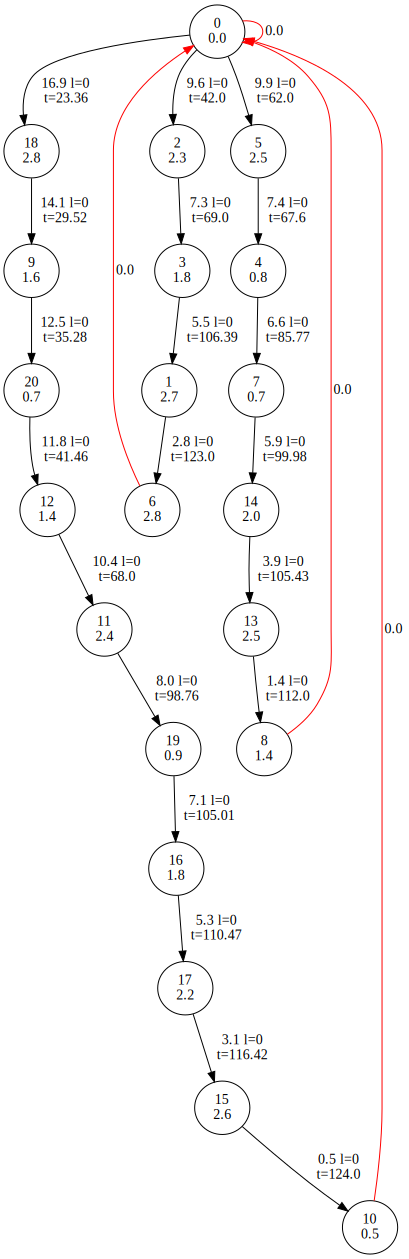

In [74]:
import graphviz as gv

G = gv.Digraph(comment='vrpltt',strict=True)
for i in range(N):
    G.node(str(i),label=str(i)+"\n"+str(demand[i])) 
print(lower)
print(upper)

for i in range(N):
    for j in range(N):
        if (x_ij[i,j].x>0):
            llevel=0
            for key,value in enumerate(z_ij[i,j,:].x):
                if value>=0.9:
                    llevel=key
                    break
            G.edge(str(i),str(j),label=f"{round(f_ij[i,j].x,1)}"+" "+f"l={llevel} \nt={round(y_i[j].x,2)}") 
            if j==0:
                G.edge(str(i),str(j),label=f"{round(f_ij[i,j].x,1)}",color="red")
display(G)

In [75]:
t_ij[1,12]


array([14.6977])

In [27]:
t_ij[0,12]

array([15.3537])

In [28]:
t_ij[1,0]

array([12.7218])

In [29]:
t_ij[17,1]

array([1.964])

In [30]:
t_ij[17,18]

array([8.7824])

In [31]:
t_ij[17,0]

array([2.358])